
Helpful Links: [Kaggle: Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview), [Getting Started with NLP](https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro), [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial/#.XkMU3Gi6OUl), [deepai.org](https://deepai.org/machine-learning-glossary-and-terms/f-score), [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c), [Kaggle NLP Course](https://www.kaggle.com/learn/natural-language-processing?utm_medium=email&utm_source=intercom&utm_campaign=nlp-course-launch), [Simple Implementation Of Word2Vec](https://www.kaggle.com/slatawa/simple-implementation-of-word2vec)

# Business Understanding


The foundation of this use case is to evaluate the ability to use tweets from Twitter users around the world to identify whether the tweet indicates a disasterous situation. The underlying questions this project seeks to answser is: When is a disaster occurring in real time? The ability to identify tweets implying a real time disaster with an acceptable degree of accuracy would enable emergency response teams to act quicker and news media outlets to report on the issue in a more timely manner.

# Data Understanding


Tweets can be posted 24/7 by millions of users. Per [David Sayce](https://www.dsayce.com/social-media/tweets-day/), a digital consultant, in October 2019 there was an average of 350,000 tweets per minute. There are numerous concerns when it comes to text analysis and the application on data that is volumnous, poor structure, different languages, and in many parts of the world.

Unfortunately, I was unable to discover answers to the following questions:

1.) What was the criteria when pulling in the train/test set. It appears to be all in English so some subset must have occurred. We also don't have an idea about WHEN the tweets occurred which could have some relevant value.

2.) There are some duplicate tweets with different labels. This is a mistake in the train/test set or perhaps they represent retweets, but retweeting doesn't change the context of the tweet and if it's related to a disaster. Why the different labels?

3.) What constitutes a disaster? There are natural disasters, political disasters. Some are subjective.

Step 1:
Read in both the test and train set for the twitter data. 

Note that the train set is composed of 5 columns (one being the target column) and 7613 observations. The test set is made of 4 columns (excludes the target column) and has 3263 observations.

In [40]:
# File system management
import numpy as np 
import pandas as pd 
import re

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Read in training data
#train_df = pd.read_csv('twitter_train.csv') # original training set
train_df = pd.read_csv('clean_training_data_1124p.csv') ## load this in order to skip the data pre-processing computation time.


# Read in test data
#test_df = pd.read_csv('twitter_test.csv')
test_df= pd.read_csv('clean_testing_data_1244p.csv')

### Describe the Dataset

In [41]:
print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

train_df.head()

Training data shape: (7613, 6)
Test data shape: (3263, 5)


,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la range saska canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,r3000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [42]:
# identify missing values
print("Count Missing Values: ")
train_df.isnull().sum()

Count Missing Values: 


id               0
keyword         61
location      2533
text             0
target           0
text_clean       0
dtype: int64

### About the Target

In [43]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

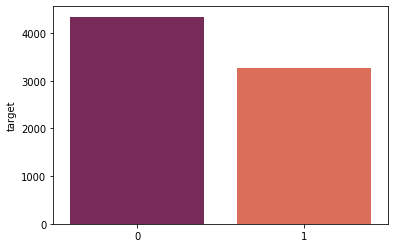

In [44]:
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(train_df['target'].value_counts().index,train_df['target'].value_counts(),palette='rocket')

In [45]:
print('Counts of label classification when the tweet actually contains the word "disaster"')
print(train_df.loc[train_df['text'].str.contains('disaster',na=False, case=False)].target.value_counts())

print('\nExamples of tweets that contain the word "disaster" but are labeled as non-disasters')
train_df.loc[(train_df['text'].str.contains('disaster',na=False, case=False)) & (train_df['target'] == 0)].head()

Counts of label classification when the tweet actually contains the word "disaster"
1    102
0     40
Name: target, dtype: int64

Examples of tweets that contain the word "disaster" but are labeled as non-disasters


,id,keyword,location,text,target,text_clean
2781,3998,disaster,"Los Angeles, London, Kent",I forgot to bring chocolate with me. Major dis...,0,forgot bring chocolate major disaster
2783,4003,disaster,Portoviejo-Manabi-Ecuador,I'm a disaster?? https://t.co/VCV73BUaCZ,0,disaster URL
2784,4005,disaster,NaN,@LovelyLikeLaura I can see why one of your fav...,0,lovelylikelaura see one favorite books beautif...
2786,4008,disaster,chillin at ceder rapids,Beautiful disaster // Jon McLaughlin is such a...,0,beautiful disaster r jon mclaughlin good song
2789,4012,disaster,en el pais de los arrechos,beautiful disaster https://t.co/qm5Sz0fyU8,0,beautiful disaster URL


    Explore the Target Variable

In [46]:
# Example of a disaster tweet
disaster_tweets = train_df[train_df['target']==1]['text']
print("Disaster Tweet: ", disaster_tweets.values[1])

# Example of a disaster tweet
not_disaster_tweets = train_df[train_df['target']==0]['text']
print("Not a Disaster Tweet: ",not_disaster_tweets.values[1])

Disaster Tweet:  Forest fire near La Ronge Sask. Canada
Not a Disaster Tweet:  I love fruits


    Explore Keyword

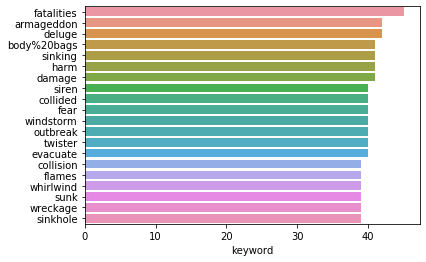

In [47]:
sns.barplot(y=train_df['keyword'].value_counts()[:20].index,x=train_df['keyword'].value_counts()[:20], orient='h')

    Explore location column

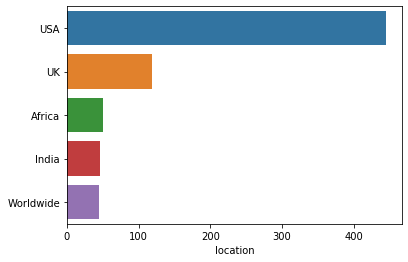

In [48]:
# Replacing the ambigious locations name with Standard names
train_df['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train_df['location'].value_counts()[:5].index,x=train_df['location'].value_counts()[:5],
            orient='h')

# Data Preparation

In [49]:
import re
import string
from IPython.display import clear_output
import timeit
import datetime
import nltk
from nltk.corpus import stopwords
from spellchecker import SpellChecker
spell = SpellChecker()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

#once preprocessing steps have been identified and complete, combine into one function such as below:

def general_preprocessing(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    return text

 # Repalce URLS 
def replace_URLS(text):
    url= re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'[URL]',text)

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def correct_mispelled_words(text):
    correct_text=[]
    incorrect_text = spell.unknown(text.split())
    for word in text.split():
        if word in incorrect_text:
            correct_text.append(spell.correction(word))
        else:
            correct_text.append(word)
    return " ".join(correct_text)

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    text = general_preprocessing(text)
    text = replace_URLS(text)
    text = remove_emoji(text)
    text = correct_mispelled_words(text)
    text = tokenizer.tokenize(text)
    text = remove_stopwords(text)
    text = combine_text(text)
    
    return text

def generate_CSV(df,file_name):
    file_name = file_name+".csv"
    df.to_csv(file_name, index=False)

def _text_preprocessing(df,df_type):
    if "text_clean" not in df:
        # If for some reason, text was NULL, remove it
        df = df.dropna(subset=["text"])
        
        # Assign the text_clean column to all values of text
        df["text_clean"] = df["text"]
        
        # Record computation time
        start= timeit.default_timer()
        
        #Loop over all rows of the dataframe
        for r in range(0, len(df)):
            
            # This allows the continuous output for the execution time.
            clear_output(wait=True)

            #Execute Text Preprocessing steps
            df['text_clean'].values[r] = text_preprocessing(df['text'].values[r])
                
            # Stop timer since steps have been completed
            stop = timeit.default_timer()
    
            # Calculate when the tasks should be complete.
            if (r/len(df)*100<5) :
                expected_time = "Calculating..."
            else:
                time_perc = timeit.default_timer()
                expected_time = np.round((time_perc-start)/(r/len(df))/60,2)
            
            # Advises if we are on the test file or train file
            print(df_type)
            print("Current Progress: ", np.round(r/len(df)*100,2),"%")
            print("Current Run Time: ", np.round((stop-start)/60,2)," minutes")
            print("Expected Run Time: ", expected_time, " minutes")
            print("\n", df['text_clean'].values[r])

        #If after the text preprocessing steps, if the text is now empty, remove it/
        df = df.dropna(subset=["text_clean"])
        # save to file so we can just load this next time.
        filename = "clean_{1}_{0:%I%Mp}".format(datetime.datetime.now(),df_type)
        generate_CSV(df,filename)
        
    return df

train_df = _text_preprocessing(train_df,"training_data")
test_df = _text_preprocessing(test_df,"testing_data")

In [50]:
#nltk.download('wordnet')
def lemmatize_text(text):
    from nltk.stem import WordNetLemmatizer
    lem = WordNetLemmatizer()
    tweet = [lem.lemmatize(word) for word in text
        if word not in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

train_df['text_clean'] = train_df['text_clean'].apply(lemmatize_text)
test_df['text_clean'] = test_df['text_clean'].apply(lemmatize_text)

TypeError: 'float' object is not iterable

In [ ]:
# Drop location, keyword, and text. Location and Keyword has too many null values. We did the preprocessing off of text
# and no longer need that column.
train_df = train_df.drop("location",axis=1)
train_df = train_df.drop("keyword",axis=1)
train_df = train_df.drop("text",axis=1)
train_df.head()

In [ ]:
# Drop location, keyword, and text. Location and Keyword has too many null values. We did the preprocessing off of text
# and no longer need that column.
test_df = test_df.drop("location",axis=1)
test_df = test_df.drop("keyword",axis=1)
test_df = test_df.drop("text",axis=1)
test_df.head()

In [ ]:
# Text Normalization
# Maybe use stemming or lemmatization?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

## BOW
bow_transform = CountVectorizer()
bow_train = bow_transform.fit_transform(train_df['text_clean'])
bow_test = bow_transform.fit_transform(test_df['text_clean'])

print(bow_train[0].todense()) #why? revisit page 64 of hands on ml book

## TFIDF
tfidf_transform = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
tfidf_train = tfidf_transform.fit_transform(train_df['text_clean'])
tfidf_test = tfidf_transform.fit_transform(test_df['text_clean'])

# Modeling


In [ ]:
# SKlearn
from sklearn import model_selection
from sklearn.metrics import f1_score
#from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
#from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.linear_model import LogisticRegression
## Logistic Regression Classifier
clf_bow = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_bow, bow_train, train_df['target'], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))
clf_bow.fit(bow_train, train_df["target"])

In [ ]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, tfidf_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))
clf_tfidf.fit(tfidf_train, train_df["target"])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# Naive Bayes Classifier - BOW
clf_nb_bow = MultinomialNB()
scores = model_selection.cross_val_score(clf_nb_bow, bow_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))

In [ ]:
clf_nb_bow.fit(bow_train,train_df["target"])

In [ ]:
# Naive Bayes Classifier - TFIDF
clf_nb_tfidf = MultinomialNB()
scores = model_selection.cross_val_score(clf_nb_tfidf, tfidf_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))

In [ ]:
clf_nb_tfidf.fit(tfidf_train,train_df["target"])

In [ ]:
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

clf_xgb_bow = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_bow, bow_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))

In [ ]:
clf_xgb_tfidf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_tfidf, tfidf_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))

### Word2Vec

In [ ]:
from nltk.tokenize import word_tokenize

train_df['tokens']=train_df['text_clean'].apply(lambda x: word_tokenize(x))
test_df['tokens']=test_df['text_clean'].apply(lambda x: word_tokenize(x))

In [ ]:
import gensim
def fn_pre_process_data(doc):
    for rec in doc:
        yield gensim.utils.simple_preprocess(rec)

corpus = list(fn_pre_process_data(train_df['text_clean']))
corpus += list(fn_pre_process_data(train_df['text_clean']))

from gensim.models import Word2Vec

print('initiated ...')
wv_model = Word2Vec(corpus,size=150,window=3,min_count=2)
wv_model.train(corpus,total_examples=len(corpus),epochs=10)

In [ ]:
def get_word_embeddings(token_list,vector,k=150):
    if len(token_list) < 1:
        return np.zeros(k)
    else:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in token_list] 
    
    sum = np.sum(vectorized,axis=0)
    ## return the average
    return sum/len(vectorized)        
def get_embeddings(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, wv_model))
        return list(embeddings)

train_embeddings = get_embeddings(train_df['tokens'],wv_model)
test_embeddings = get_embeddings(test_df['tokens'],wv_model)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_model = LogisticRegression()
grid_values ={'penalty':['l1','l2'],'C':[0.0001,0.001,0.01,0.1,1,10]}
grid_search_model = GridSearchCV(lr_model,param_grid=grid_values,cv=3)
grid_search_model.fit(train_embeddings,train_df['target'])
print(grid_search_model.best_estimator_)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

predict_lr = grid_search_model.predict(test_embeddings)

In [ ]:
predict_df = pd.DataFrame()
predict_df['id'] = test_df['id']
predict_df['target'] = predict_lr
predict_df.to_csv('sample_submission_100.csv', index=False)

### SVM

In [ ]:
from sklearn.svm import SVC

svc_model = SVC()
grid_values ={'C':[0.0001,0.001,0.01,0.1,1,10]}

grid_search_model = GridSearchCV(svc_model,param_grid=grid_values,cv=3)
grid_search_model.fit(train_embeddings,train_df['target'])
print(grid_search_model.best_estimator_)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

predict_svc = grid_search_model.predict(test_embeddings)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()
grid_values ={'n_estimators':[10,50,100,150,200,300,400]}

grid_search_model = GridSearchCV(rf_model,param_grid=grid_values,cv=3)
grid_search_model.fit(train_embeddings,train_df['target'])
print(grid_search_model.best_estimator_)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

predict_rf = grid_search_model.predict(test_embeddings)

# Evaluation


## F1 Score
The evaluation metric that the Kaggle competition uses is the F1 score. This paragraph is meant to define the F1 score and understand what contributes to this score.

According to [deepai.org](https://deepai.org/machine-learning-glossary-and-terms/f-score), the F1 score is the harmonic mean of the precision and recall.

[Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c), a blog published on Towards Data Science, authored by Will Koehresen helps us define each piece of the F1 Score.

Precision - the proportion of positive results that are truly positive. The calculation is the count of correctly identified disasters divided by every observation labeled as a disaster regardless of correctness. The score is penalized by the incorrectly labeled "disaster" observations .

Recall - measures the model's ability to identify true positives in a dataset. The true positives are divided by all positive instances, regardless of the model's ability to correctly identify them. This score is penalized by classifying true disasters observations as false (not a disaster).

![title](img/recall_df.png)
![title](img/precision_df.png)

In [ ]:
def _recall(true_positives, false_negatives):
    return (true_positives)/(true_positives + false_negatives)
def _precision(true_positives, false_positives):
    return (true_positives)/(true_positives + false_positives)
def _f1(precision, recall):
    return (precision*recall)/(precision+recall)

In [ ]:
print(train_df['target'].value_counts())

true_positives = 3171
total_observations = 7613
# If we were to hypothetically set all observations to DISASTER
false_positives = total_observations-true_positives
recall = _recall(true_positives,0)
precision = _precision(true_positives,false_positives)
print('\n\nIF ALL OBSERVATIONS WERE SET TO DISASTER (POSITIVE)')
print('RECALL: ', recall)
print('PRECISION: ', precision)
print('F1: ', _f1(precision, recall))

# If we were to hypothetically set all observations to NOT A DISASTER
print('\n\nIF ALL OBSERVATIONS WERE SET TO NOT DISASTER (NEGATIVE)')
print('RECALL: 0 ')
print('PRECISION: 0')
print('F1: 0')

# If we were to hypothetically set all observations to NOT A DISASTER but correctly identified 1 disaster
false_negatives = total_observations - 1
true_positives = 1
false_positives = 0
recall = _recall(true_positives,false_negatives)
precision = _precision(true_positives,false_positives)
print('\n\nIF ALL OBSERVATIONS WERE SET TO NOT DISASTER (NEGATIVE) But 1 correctly identified true positive')
print('RECALL: ', recall)
print('PRECISION: ', precision)
print('F1: ', _f1(precision, recall))

To summarize the above findings: If we label all tweets as positive disasters, then we have a high recall because we identified all disasters, but a low precision because we also incorrectly labeled many non disasters as disasters. In contrast, if we identified one true positive, but labeled the rest negatives, then the precision is high because we didn't incorrectly identify any non disasters as disasters, but recall is low because we missed many true disasters.


Thinking about this from a cost/benefit perspective, if every tweet was labeled as a disaster (high recall, low precision), then the resources used to report and investigate the disaster is very costly. If ever tweet was labeled no disaster, then there is no benefit from using the model. Many true disasters are missed, which could cost the organization in their reputation from having a delayed reaction time to true emergencies. In this situation a true balance between recall and precision is desired.

A higher F1 score represents optimizing the balance between precision and recall.

## Confusion Matrix

## ROC Curve and AUC

# Deployment

In [ ]:
## Deployment Code

In [ ]:
def generate_CSV(df,file_name):
    file_name = file_name+".csv"
    df.to_csv(file_name, index=False)
    
#submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
#test_vectors=test_tfidf
#submission(submission_file_path,clf_NB_TFIDF,test_vectors)